In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science'])
mpl.rcParams["font.size"] = "12"

import torch
import torch.nn.init as init

from modules.utils import FeedForwardNetwork, plot_pde, plot_losses, rmse
from modules.problems import Diffusion

In [6]:
def train(
    problem,
    model,
    N_LB, N_RB, N_I, N_D,
    coef, lr, num_iters,
    print_every=1000, collect_every=1000
):
    x_sampled = torch.tensor(np.random.uniform(problem.L, problem.R, N_I), dtype=torch.float32)
    t_left_sampled =  torch.tensor(np.random.uniform(0, problem.T, N_LB), dtype=torch.float32)
    t_right_sampled = torch.tensor(np.random.uniform(0, problem.T, N_RB), dtype=torch.float32)
    
    def nearest_index(array, values):
            values = [np.abs(array - v).argmin().item() for v in values]
            return values
    
    problem.left_values =  problem.left_boundary [nearest_index(problem.t, t_left_sampled) ]
    problem.right_values = problem.right_boundary[nearest_index(problem.t, t_right_sampled)]
    problem.init_values =  problem.initial_values[nearest_index(problem.x, x_sampled)      ]

    x_pts = torch.tensor(np.random.uniform(problem.L, problem.R, N_D), requires_grad=True, dtype=torch.float32).reshape(-1, 1)
    t_pts = torch.tensor(np.random.uniform(0, problem.T, N_D), requires_grad=True, dtype=torch.float32).reshape(-1, 1)

    test_points = torch.cartesian_prod(problem.x, problem.t)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses, errors = [], []

    for i in range(num_iters + 1):

        optimizer.zero_grad()

        L_B, L_I = problem.loss_boundary(model, t_left_sampled, t_right_sampled, x_sampled)
        L_D = problem.loss_physical(model, x_pts, t_pts)

        total = coef * (L_B + L_I) + (1 - coef) * L_D

        total.backward()
        optimizer.step()
                
        if i % collect_every == 0:
            with torch.no_grad():
                preds = model(test_points).reshape(problem.Nx, problem.Nt).detach().numpy()
                error = rmse(preds.T, problem.solution)
                
                losses.append(np.array([L_I.item(), L_B.item(), L_D.item(), total.item()]))
                errors.append(error)
                
        if i % print_every == 0:
            print(f'Iteration {i} --- Loss {total.item()} --- RMSE {error}')
                
    return np.array(losses), np.array(errors)

In [ ]:
D = 0.5
L, R, T = 0, 1, 0.5
Nt, Nx = 1000, 250
left_boundary = right_boundary = torch.zeros(Nt)
initial_conditions = torch.sin(2 * np.pi * torch.linspace(L, R, Nx)) ** 2

problem = Diffusion(
    D, (L, R, T), (Nt, Nx),
    (left_boundary, right_boundary, initial_conditions)
)

plot_pde(problem.x, problem.t, problem.solution, size=(6.5, 3))

In [ ]:
L, W = 2, 32
model = FeedForwardNetwork(L, W, input_dim=2, output_dim=1)

N_I, N_LB, N_RB, N_D = 42, 12, 12, 1024
coef = 0.8
lr = 1e-3
num_iters = 5000
collect_every = 250

losses, errors = train(
    problem,
    model,
    N_LB, N_RB, N_I, N_D,
    coef=coef, lr=lr, num_iters=num_iters,
    collect_every=collect_every, print_every=2500
)

In [ ]:
test_points = torch.cartesian_prod(problem.x, problem.t)
predictions = model(test_points).reshape(Nx, Nt).detach().numpy()
plot_pde(problem.x, problem.t, predictions.T, size=(6.5, 3))

In [ ]:
plot_pde(problem.x, problem.t, np.abs(predictions.T - problem.solution), size=(6.5, 3))

In [ ]:
plt.style.use(['grid'])

plot_losses(
    np.arange(0, num_iters+1, collect_every),
    losses=[
        (losses[:,0], r'$\mathcal{L_I}$'),
        (losses[:,1], r'$\mathcal{L_B}$'),
        (losses[:,2], r'$\mathcal{L_D}$'),
        (losses[:,3], r'$\mathcal{L_T}$')
    ],
    errors=[
        (errors, r'RMSE'),
    ]
)

## Interesting problem statements
---

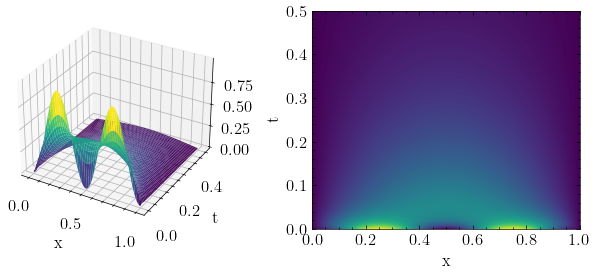

In [2]:
# Default

D = 0.5
L, R, T = 0, 1, 0.5
Nt, Nx = 1000, 250
left_boundary = right_boundary = torch.zeros(Nt)
initial_conditions = torch.sin(2 * np.pi * torch.linspace(L, R, Nx)) ** 2

problem = Diffusion(
    D, (L, R, T), (Nt, Nx),
    (left_boundary, right_boundary, initial_conditions)
)

plot_pde(problem.x, problem.t, problem.solution, size=(6.5, 3))

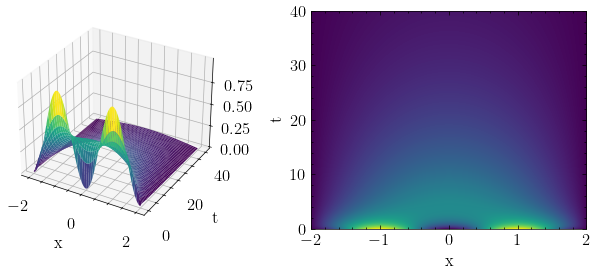

In [86]:
# Solution is visually indistinguishable from default, but parameters have changed.
# Will hyperparameters change too?

D = 0.1
L, R, T = -2, 2, 40
Nt, Nx = 1000, 250
left_boundary = right_boundary = torch.zeros(Nt)
initial_conditions = torch.sin(0.5 * np.pi * torch.linspace(L, R, Nx)) ** 2

problem = Diffusion(
    D, (L, R, T), (Nt, Nx),
    (left_boundary, right_boundary, initial_conditions)
)

plot_pde(problem.x, problem.t, problem.solution, size=(6.5, 3))

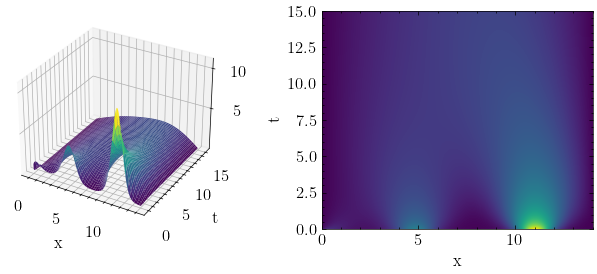

In [66]:
# Solution with two concentration peaks (plus one small on the left).

def f(x):
    return torch.exp(torch.sin(x)*torch.log(1/(x + np.finfo(float).eps)))

D = 0.4
L, R, T = 0, 14, 15
Nt, Nx = 1000, 250
left_boundary = f(torch.exp(torch.linspace(0, T, Nt)) / f(torch.tensor([L])))
right_boundary = f(torch.exp(torch.linspace(0, T, Nt)) / f(torch.tensor([R])))
initial_conditions = f(torch.linspace(L, R, Nx))

problem = Diffusion(
    D, (L, R, T), (Nt, Nx),
    (left_boundary, right_boundary, initial_conditions)
)

plot_pde(problem.x, problem.t, problem.solution, size=(6.5, 3))

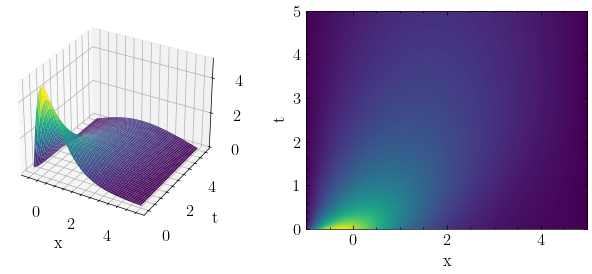

In [80]:
# Heat transfer with constant cold boundaries.

D = 0.7
L, R, T = -1, 5, 5
Nt, Nx = 1000, 250
left_boundary = right_boundary = torch.zeros(Nt)
initial_conditions = torch.sin(torch.exp(-torch.linspace(L, R, Nx) + 0.145))*5

problem = Diffusion(
    D, (L, R, T), (Nt, Nx),
    (left_boundary, right_boundary, initial_conditions)
)

plot_pde(problem.x, problem.t, problem.solution, size=(6.5, 3))